## The Big Wave
Progect Leads: Trevor McLean, Avery Meyers

### Introduction

This project aims to take tsunami tide guage data, process it in python, and plot it for readability and analysis.  We are examining three tsunamis events: the Japan 2011 tsunami, the Chile 2010 tsunami, and the Solomon Islands 2013 tsunami.  Our data was gathered from the IOC webside ioc-sealevelmonitoring.org, and additional information about the associated earthquake events was provided by USGS.gov and sms-tsunami-warning.com.

What is a Tsunami?

Tsunamis are large waves caused primarily by volumetric disturbances in the ocean.  Examples of these triggering events include land-slides, volcanoes, and most commonly earthquakes. 

The term tsunami was adopted from Japanese around WW2:'Tsu' meaning harbor and 'Nami' meaning wave.

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2index
import math


def read_data(f_name):
    '''(str) -> (list, list)
    
    Takes in a file of primary water levels against time and parses the data into
    two lists: a list of times and a list of primary water level(pwl). Returns those
    lists in a tuple.
    '''
    with open(f_name, 'r') as f_temp:
        f_temp.readline()
        f_temp.readline()
        L_time = []
        L_pwl = []
        
        for i in f_temp:
            L_temp = i.strip().split('\t')
            L_time.append(L_temp[0])
            L_pwl.append(float(L_temp[1]))
                         
    return L_time, L_pwl


def read_lat_lon(name):
    with open(name, 'r') as f:
        f.readline()
        stations = {}
        for l in f:
            temp_l = l.strip().split(',')
            stations[temp_l[0]] = (float(temp_l[1]), float(temp_l[2]))
        return stations
            

                         
def data_point_time(L_time):
    '''(list) -> list
    
    Takes in a list of times L_times in the formal of files from the IOC and reduces it down
    to a series of integers representative of the amount of minutes that have passed at any 
    given point. Returns a list of equal length that contains float quantities of minutes 
    passed.
    
    >>> data_point_time(['2011-03-11 00:05:00', '2011-03-11 01:23:00'])
    [5, 83]
    >>> data_point_time(['2011-03-11 00:00:00', '2011-03-11 01:23:00', '2011-03-11 01:23:00', '2011-03-11 01:23:00'])
    [0, 83, 83, 83]
    '''
    
    L_time_initial = L_time[0]
    format_time = L_time_initial.split()
    format_time_list = format_time[0].split('-') + format_time[1].split(':')
    base_time = dt.datetime(year=int(format_time_list[0]),
                            month=int(format_time_list[1]),
                            day=int(format_time_list[2]), 
                            hour=int(format_time_list[3]), 
                            minute=int(format_time_list[4])
                           )
    
    L_time_minutes = []
    for time in L_time:
        temp_time = time.split()
        temp_time_list = temp_time[0].split('-') + temp_time[1].split(':')
        current_time = dt.datetime(year=int(temp_time_list[0]),
                                    month=int(temp_time_list[1]),
                                    day=int(temp_time_list[2]), 
                                    hour=int(temp_time_list[3]), 
                                    minute=int(temp_time_list[4])
                                   )
        time_difference = (current_time - base_time).total_seconds() / 60
        L_time_minutes.append(time_difference)
        
    return L_time_minutes

def calculate_amplitudes(L_time, L_pwl):
    '''(list, list) -> dict
    
    Takes in a list of times L_time and a list of precision water levels L_pwl and calculates
    a right-side amplitude approximation for every wave of the plot. Returns those amplitudes
    as values paired with a key of the time of the peak for each amplitude in a dictionary.
    '''
    
    start = 0
    end = 0
    amplitudes = {}
    for i in range(1, len(L_pwl)):
        if (len(L_pwl) - 1) == i:
            break
            
        if L_pwl[i] < L_pwl[i+1] and L_pwl[i-1] >= L_pwl[i]:
            start = L_pwl[i]
        elif L_pwl[i] > L_pwl[i+1] and L_pwl[i-1] <= L_pwl[i]:
            end = L_pwl[i]
            peak = i
            
        if start and end:
            amplitudes[L_time[peak]] = 100 * round(((abs(end-start)) / 2), 4)
            start = 0
            end = 0
            
    return amplitudes

def find_start(time_list, pwl_list):
    '''
    (list, list) -> num

    Takes in a list of times and percision water levels and returns an index on the x axis where 
    the start of a tsunami event can be graphed.

    '''
    running_avg = 0
    last_total = 0
    for i in range(1, len(pwl_list)):
        diff = abs(pwl_list[i] - pwl_list[i-1])
        if i > 30:
            if diff > running_avg*6.3:
                return time_list[i]
            else:
                last_total = last_total + diff
                running_avg = last_total/i
        else: 
            last_total = last_total + diff
            running_avg = last_total/i
    return None

def determine_max(sub_dict):
    '''(dict) -> float
    
    '''
    amps = sub_dict['amps']
    ctr = 0
    for time in amps:
        if amps[time] > ctr:
            ctr = amps[time]
    #if time <= sub_dict['start'] + 30:
            
    return ctr

def find_distance(epilat, epilon, stations):
    
    #In Kilometers
    R = 6373.0

    lat1 = math.radians(epilat)
    lon1 = math.radians(epilon)

    distances = []

    for station in stations:
        lat2 = math.radians(station[0])
        lon2 = math.radians(station[1])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        #Haversine formula
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        distances.append(distance)
    return distances


def info_structure(station_files, lat_lon_file, station_names, tsunami_name):
    '''(list, str) -> dict
    
    '''
    super_dict = {}
    
    latlon_dict = read_lat_lon(lat_lon_file)
    
    index = 0
    for file in station_files:
        sub_dict = {}
        temp_times, temp_pwls = read_data(file)
        sub_dict['long_times'] = temp_times
        sub_dict['pwls'] = temp_pwls
        sub_dict['times'] = data_point_time(temp_times)
        sub_dict['amps'] = calculate_amplitudes(sub_dict['times'], temp_pwls)
        sub_dict['start'] = find_start(sub_dict['times'], temp_pwls)
        sub_dict['max_amp'] = determine_max(sub_dict)
        sub_dict['lat_lon'] = latlon_dict[station_names[index]]
        sub_dict['dist'] = find_distance(latlon_dict[tsunami_name][0], latlon_dict[tsunami_name][1], [sub_dict['lat_lon']])[0]
        super_dict[station_names[index]] = sub_dict
        index += 1
        
    super_dict['tsu_lat_lon'] = latlon_dict[tsunami_name]
    super_dict['station_names'] = station_names
    super_dict['name'] = tsunami_name
    
    return super_dict


#Data Setup
Japan_2011 = info_structure(['Japan(Omaezaki).txt', 'Japan(Honiara).txt', 'Japan(Westport_WA).txt'],
                            'Lat_Lon.txt',
                            ['Omaezaki', 'Honiara', 'Westport WA'],
                            'Japan 2011'
                           )

Chile_2010 = info_structure(['Chile(Omaezaki).txt', 'Chile(Antofagasta_CL).txt', 'Chile(San_Felix_CL).txt'],
                            'Lat_Lon.txt',
                            ['Omaezaki', 'Antofagasta CL', 'San Felix CL'],
                            'Chile 2010'
                           )

Solomon_2013 = info_structure(['Solomon_Islands(Honiara).txt', 'Solomon_Islands(Lata_Wharf_SB).txt', 'Solomon_Islands(Lautoka_FJ).txt'],
                            'Lat_Lon.txt',
                            ['Honiara', 'Lata Wharf SB', 'Lautoka FJ'],
                            'Solomon Islands 2013'
                           )

print(Japan_2011['Omaezaki']['start'])

tsunamis = [Japan_2011, Chile_2010, Solomon_2013]

373.0


### Explination of base functions

#### Info gathered from(primarily) USGS.gov and sms-tsunami-warning.com
#### Data gathered from ioc-sealevelmonitoring.org

##### Japan 2011, Miyagi Prefecture Tsunami: Caused by a 9.0 magnitude undersea earthquake on March 11 
##### Chile 2010, Maule: Caused by a 8.8 magnitude earthquake on February 27 
##### Solomon Islands, Lata 2013: Caused by a 8.0 magnitude earthquake on February 06 



### Introduction of data

IOC gathers tide guage data from monitoring stations around the world.  Gathering this data proved challenging.  Many of the stations were established years after the tsunami events we were examining, possibly in response to the disasters.  We also discovered stations with broken equipment, which would result in choppy or wildy innacurate measurements.  

In the end, we found data from three stations per tsunami event.  This data comes in the form of a timestamp and a precision water level in meters.  Omaezaki and Honaira stations appear twice, as their readings proved reliable and multiple tsunamis showed for them.  

We took five days of readings for the Japan and Chile events, and two days from the Solomon Islands event whose irregular behavior tapered out faster.  

Below we have the raw data from the IOC plotted, with a blue line denoting when the event begins.  The precision water level is taken in meters, and the x-axis represents minutes after 12:00 AM the morning of the tsunami.  

Note that it takes fewer days for the Solomon islands tsunami to subside.  Also note that the algorithm we wrote to determine the begining of the tsunami is sometimes thrown off by a sudden, smaller fluxuation in water level that preceeds a major fluxation such as what in the Honiara reading for Japan 2011.  

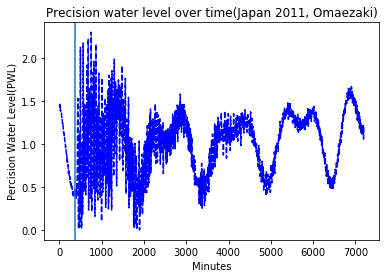

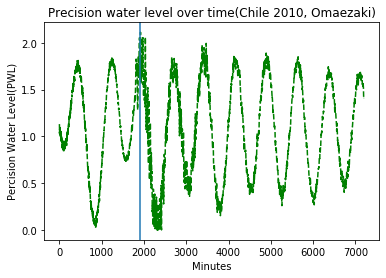

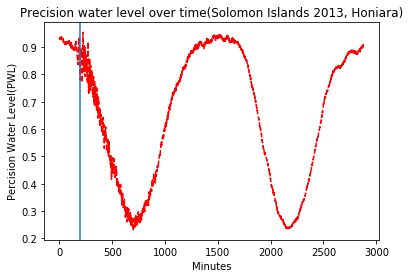

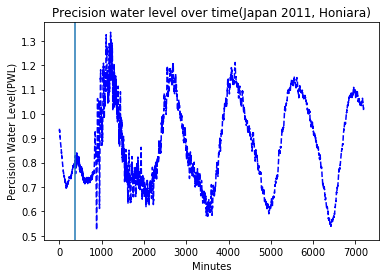

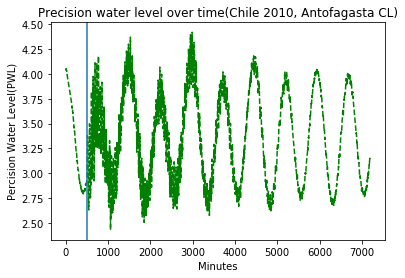

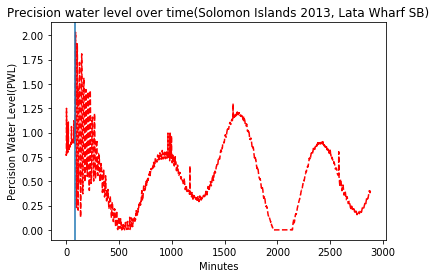

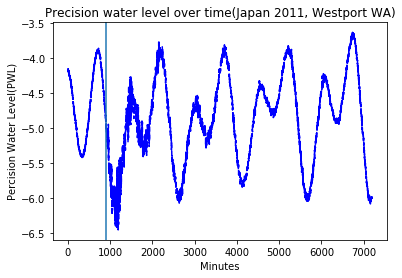

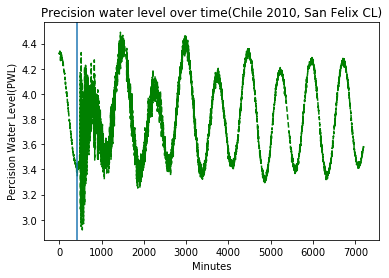

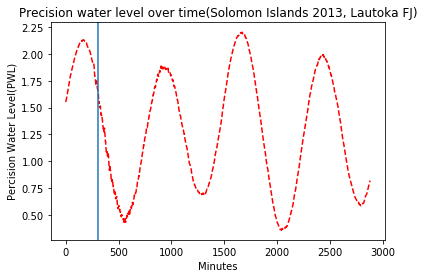

In [2]:
def plot_variation(info_structure, station_name, color):
    '''(list(lists), list(lists)) -> None
    
    Graphs a representation of the water level change over time for multiple different sets of data. 
    Takes in two lists of lists where each internal list of the list time_lists is the times of data collection
    converted to minutes by the function data_point_time. The list pwl_lists contains lists of precision water level
    associated with the respective index of list of time points. This function returns none and prints all given 
    pairs of time and pwl lists. There must be equal amounts of lists in time_lists and pwl_lists. As well, those
    lists must be of equal length.
    '''
    # FIXME (docstring)
    
    plt.figure()
    times = info_structure[station_name]['times']
    pwls = info_structure[station_name]['pwls']
    plt.plot(times, pwls, color + '--') 
    plt.axvline(find_start(times, pwls))
    plt.title(f'Precision water level over time' + '(' + info_structure['name'] + ', ' + station_name + ')')
    plt.xlabel('Minutes')
    plt.ylabel('Percision Water Level(PWL)')
    
colors= ['b', 'g', 'r']
    
for i in range(3):
    plot_variation(tsunamis[i], tsunamis[i]['station_names'][0], colors[i])
for i in range(3):
    plot_variation(tsunamis[i], tsunamis[i]['station_names'][1], colors[i])
for i in range(3):
    plot_variation(tsunamis[i], tsunamis[i]['station_names'][2], colors[i])

### Discussion of data

Tsunami fluxuations appear as more of an alteration of normal tides, meaning that the tide still follows normal behaviour in spite of the tsunami. Later in the data we will see a graphic of the amplitude approximations to show the data without the fluctuation of tide.  What first surprised us about this data was that the tsunamis appear as violent jirations on an otherwise consistent pattern of high and low tides. A tsunami can make these normal tide fluxuations appear more pronounced, and a violent one can disrupt them entirely such as what is read on the Omaezaki plot for Japan 2011.

### Introduction of data

The latitude and longitude of earthquakes (gathered by the USGS) as well as tide guage stations are plotted on this Mercator projection generated by Basemap. To get this data, we essentially had to record it into a text file manually before we read it into our program; we even wrote a specialized function for the task.  

Earthquake epicenters appear as large dark colored diamonds, and associated stations appear as lighter versions of those same colors.  Note that the two stations are used multiple times, and are thus overlapped.  After experimenting with different types of projections and formats, we decided that a minmalist approach with just the coastlines and stations plotted was the most readable.  

In [7]:
def world_map_plot(info_structures):
    '''(list) -> None
    
    '''
    
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    m = Basemap(projection = 'merc', llcrnrlat = -80, urcrnrlat = 80, llcrnrlon = -180, urcrnrlon = 180, lat_ts = 20, resolution = 'c', lat_0=90, lon_0=-170)
    #, llcrnrlat = -80, urcrnrlat = 80, llcrnrlon = -180, urcrnrlon = 180, lat_ts = 20, resolution = 'c'
    
    #m.shadedrelief()
    m.drawcoastlines()
    m.drawmapboundary(fill_color = 'aqua')
    m.fillcontinents(color = 'mediumaquamarine')
    
    
    colors1= ['dodgerblue', 'g', 'indianred']
    colors2= ['midnightblue', 'darkgreen', 'darkred']
    for tsunami in info_structures:
        lats = []
        lons = []
        for station in tsunami['station_names']:
            lons.append(tsunami[station]['lat_lon'][1])
            lats.append(tsunami[station]['lat_lon'][0])
            
        x, y = m(lons, lats)
        m.scatter(x, y, marker='H', color=colors1.pop())
        
        x2, y2 = m(tsunami['tsu_lat_lon'][1], tsunami['tsu_lat_lon'][0])
        m.plot(x2, y2, marker='X', color=colors2.pop(), markersize=10)
    
    plt.show()


### Discussion of data

### Introduction of data

Amplitude of the wave readings are represented as scatter plots to illustrate how the wave subsides over time.  Amplitude is measured in centimeters, and and the timescale is once again measured in minutes after 12:00 AM the morning of the tsunami.  These amplitudes are calculated for each time stamp using the calculate_amplitudes() function, which takes in times and precision water levels and calculates a right-side amplitude approximation for each station.  

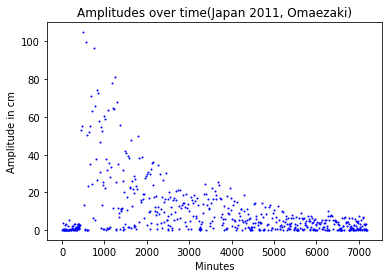

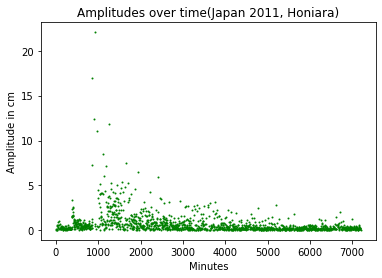

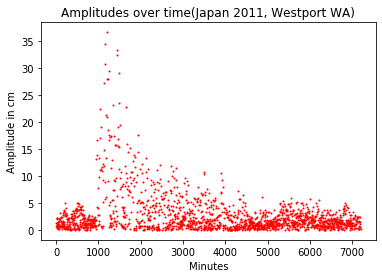

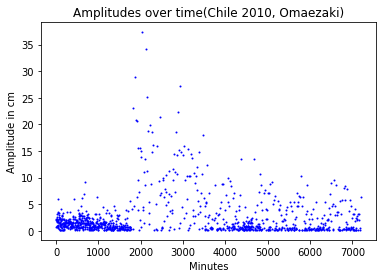

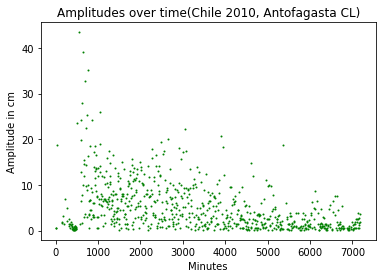

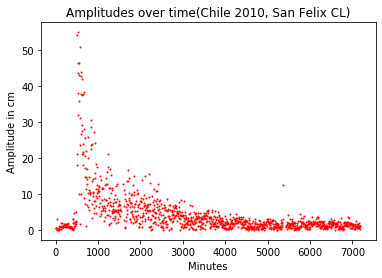

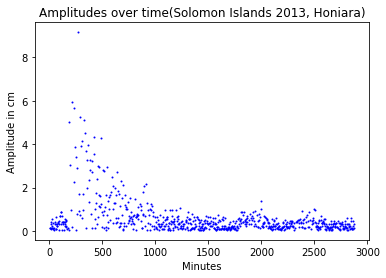

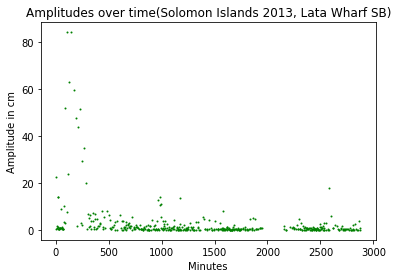

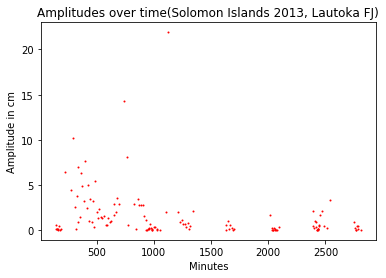

In [6]:
def plot_amplitude(info_structure, station, c):

    t1 = []
    a1 = []

    for time in info_structure[station]['amps']:
        t1.append(time)
        a1.append(info_structure[station]['amps'][time])

    plt.figure()
    plt.scatter(t1, a1, color = c, s = 1)
    plt.title('Amplitudes over time' + '(' + info_structure['name'] + ', ' + station + ')')
    plt.xlabel('Minutes')
    plt.ylabel('Amplitude in cm')
    
colors= ['b', 'g', 'r']
    
for n in range(3):
    for i in range(3):
        plot_amplitude(tsunamis[n], tsunamis[n]['station_names'][i], colors[i])

### Discussion of data

### Introduction of data

Max amplitudes are based off of full run of data, not first 30 minutes.  We made this choice because sometimes the beginning  of the tsunami as calculated would happen more than thirty minutes before the amplitude truly maxed out, so we tried to keep it as accurate as possible.  

Here we've ploted the nine stations' distances from the triggering earthquake's epicenter vs the max amplitude in centimeters.  Results from this calculation are certainly not as straightforward as the previous plots, as you'll see.

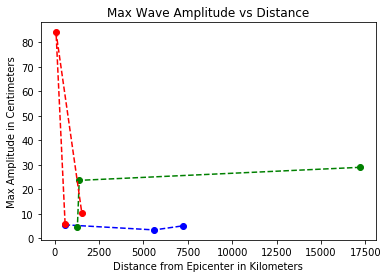

In [60]:
def plot_amps_distances(dictionaries):
    color = ['bo--', 'go--', 'ro--']
    c_i = 0
    plt.figure()
    for dictionary in dictionaries:
        station_names = dictionary['station_names']
        epi_lat_lon = dictionary['tsu_lat_lon']
        name = dictionary['name']
        
        stations_lat_lon = []
        max_amps = []
        for s in station_names:
            max_amps.append(dictionary[s]['max_amp'])
            stations_lat_lon.append(dictionary[s]['lat_lon'])

        distances = find_distance(epi_lat_lon[0], epi_lat_lon[1], stations_lat_lon)
        plt.plot(distances, max_amps, color[c_i])
        c_i = c_i + 1
    plt.title('Max Wave Amplitude vs Distance')
    plt.xlabel('Distance from Epicenter in Kilometers')
    plt.ylabel('Max Amplitude in Centimeters')
    
plot_amps_distances(tsunamis)

### Discussion of data

### Introduction of data
This last plot takes the highest amplitude we could find for each tsunami devided by the distance in km of that reading from the epicenter.  The outlying nature of this data point is further highlighted here, as it is especially pronounced for the Solomon Islands tsunami and barely visible for the other two.    

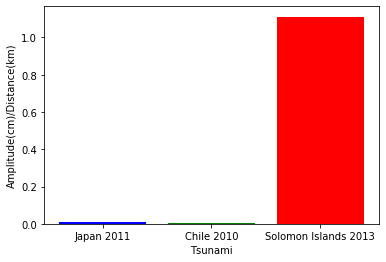

In [61]:
def plot_amp_max_per_tsunami(info_structures, L_color_code):
    '''(list, list) -> None
    
    '''
   
    plt.figure()
    plt.xlabel('Tsunami')
    plt.ylabel('Amplitude(cm)/Distance(km)')
    ctr = 0
    for tsunami in info_structures:
        max_amps = []
        max_amp = 0
        for station in tsunami['station_names']:
            max_temp = max_amp
            max_amps.append(tsunami[station]['max_amp'])
            max_amp = max(max_amps)
            if max_amp != max_temp:
                station_max = station
        value = (max(max_amps)) / (tsunami[station_max]['dist'])
        plt.bar(tsunami['name'], value, color = L_color_code[ctr])
        ctr += 1
    plt.show()
    
plot_amp_max_per_tsunami(tsunamis, ['b', 'g', 'r'])

### Discussion of data

### Conclusion